In [89]:
# pip install keras-tuner
# !pip3 install --force-reinstall -v tensorflow==2.15.0
# print(tf.__version__)
!pip3 install tensorflow==2.15.0
# print(tf.__version__)

Defaulting to user installation because normal site-packages is not writeable


In [90]:
import pandas as pd
from IPython.display import clear_output
import io
import os
import glob
import zipfile
import shutil


import numpy as np
import random as python_random
import matplotlib.pyplot as plt
from numpy import linalg as LA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
print(tf.__version__)
tf.config.set_visible_devices([], 'GPU')
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,BatchNormalization, Dropout
from tensorflow.keras.metrics import AUC
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import EarlyStopping

# from kerastuner.tuners import RandomSearch
# from kerastuner import Objective

import sklearn.metrics as sklm
from cxr_foundation import embeddings_data

seed=19
np.random.seed(seed)
python_random.seed(seed)
tf.random.set_seed(seed)

2.15.0


In [91]:
base_path="."

In [92]:
data_df=pd.read_csv(base_path+"/Extracted_Embeddings/processed_mimic_df.csv")

In [93]:
data_df.split.value_counts()

split
train       108952
validate     13936
test         13574
Name: count, dtype: int64

In [94]:
df_train = data_df[data_df["split"] == "train"]
df_validate = data_df[data_df["split"] == "validate"]

df_test = data_df[data_df["split"] == "test"]

# Preparing Embeddings Files for Model Training

We want to detect race of a patient using the embeddings with this label.

In [95]:
TrueWithMeta = df_test.loc[:, ~df_test.columns.isin(['study_id','split'])]
TrueWithMeta.reset_index(drop=True,inplace=True)
print(f'length of df_test : {len(TrueWithMeta)}')

# base_path="D:/Academics/Master/Thesis/MIMIC_CXR_EMB/Vector_Embedded/Seed_"+str(seed)+"/"
#base_path

prediction_results_path=os.path.join(base_path+"/Prediction_Results/")
os.makedirs(os.path.dirname(prediction_results_path),exist_ok=True)
TrueWithMeta.to_csv(prediction_results_path+"TrueWithMeta.csv")


print(f'prediction path : {prediction_results_path}')

length of df_test : 13574
prediction path : ./Prediction_Results/


In [96]:
labels_Columns=['Atelectasis','Cardiomegaly','Consolidation','Edema','Enlarged_Cardiomediastinum',
        'Fracture','Lung_Lesion','Lung_Opacity','No_Finding','Pleural_Effusion','Pleural_Other',
        'Pneumonia','Pneumothorax','Support_Devices']


In [97]:
# Create training and validation Datasets
training_data = embeddings_data.get_dataset(filenames=df_train.path.values,
                        labels=df_train[labels_Columns].values)

validation_data = embeddings_data.get_dataset(filenames=df_validate.path.values,
                        labels=df_validate[labels_Columns].values)

In [98]:
for data in training_data.take(2):
  print(data)

(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.36118683, -0.5544699 ,  0.82848966, ..., -1.2692559 ,
        0.8680941 , -1.7307097 ], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])>)
(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([ 0.00790492, -1.233756  ,  1.4638388 , ...,  0.16128573,
        1.1709231 , -2.2127128 ], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])>)


In [99]:
for data in validation_data.take(2):
  print(data)

(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.76881164, -0.35455763,  0.55263436, ..., -1.7078307 ,
        0.55289423, -0.67891777], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.])>)
(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.37028256, -0.4382674 , -0.18898396, ..., -1.2663532 ,
        0.11181889, -0.8853314 ], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])>)


In [100]:

test_data = embeddings_data.get_dataset(filenames=df_test.path.values,labels=df_test[labels_Columns].values)
for _d in test_data.take(2):
  print(_d)


(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([ 0.75120676, -1.6077417 ,  1.1188964 , ..., -1.0535457 ,
        1.2617992 , -0.6080363 ], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])>)
(<tf.Tensor: shape=(1376,), dtype=float32, numpy=
array([-0.7226969, -1.5087104,  0.94791  , ..., -1.3294164,  1.1765957,
       -0.6002594], dtype=float32)>, <tf.Tensor: shape=(14,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])>)


# Create and Train Model

### Optimal hyperparameters


In [101]:
# These parameters are obtained by doing hyperparameter tuning 
embeddings_size=1376
learning_rate=0.0001253
batch_size = 32
epochs = 50
end_lr_factor=1.0
dropout=0.4
decay_steps=1000
loss_weights=None
weight_decay = 1.1342834436836775e-05
hidden_layer_sizes = [192]


In [102]:
checkpoint_path = base_path+"/model_checkpoint/"
# Create directory model weightes saving
save_model_dir = os.path.join(checkpoint_path,'models')
os.makedirs(os.path.dirname(save_model_dir), exist_ok=True)

def get_callbacks(patience=5):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             mode="min",
                                             patience=patience,
                                             restore_best_weights=True)
    saved_model = tf.keras.callbacks.ModelCheckpoint(f'{save_model_dir}/model.n5',
                                                monitor='val_auc',
                                                mode='max',
                                                save_freq='epoch',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                verbose=1)
    saved_model = tf.keras.callbacks.ModelCheckpoint(f'{save_model_dir}/model.h5',
                                                    monitor='val_auc',
                                                    mode='max',
                                                    save_freq='epoch',
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    verbose=1)
    callbacks_list = [early_stop,
                      saved_model,
                     ]
    return callbacks_list

In [103]:
# Normal trainning
# # Define a function to build the model
# def build_model(
#     # hp
#     ):

#     #Hyperparameters
#     # learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
#     # batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128,256])
#     # dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
#     # weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling='log')
#     # hidden_layer_sizes = [hp.Int(f'hidden_{i}', min_value=64, max_value=512, step=64) for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=4))]

#     # Define the input layer
#     inputs = Input(shape=(embeddings_size,))

#     # Build the model using the Functional API
#     hidden = inputs
#     for size in hidden_layer_sizes:
#         hidden = Dense(size,
#                        activation='relu',
#                        kernel_initializer=HeUniform())(hidden)
#         hidden = BatchNormalization()(hidden)
#         hidden = Dropout(dropout)(hidden)

#     output = Dense(len(labels_Columns), activation='sigmoid', kernel_initializer=HeUniform())(hidden)

#     # Create the model
#     model = Model(inputs=inputs, outputs=output)

#     # Compile the model with AUC as the metric
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss='binary_crossentropy',
#                   metrics=[AUC(multi_label=True)])

#     return model

In [104]:
# Define a function to build the model
def build_model(
    # hp
    ):

    #Hyperparameters
    # learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    # batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128,256])
    # dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    # weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling='log')
    # hidden_layer_sizes = [hp.Int(f'hidden_{i}', min_value=64, max_value=512, step=64) for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=4))]

    # Define the input layer
    inputs = Input(shape=(embeddings_size,))

    # Build the model using the Functional API
    hidden = inputs
    for size in hidden_layer_sizes:
        hidden = Dense(size,
                       activation='relu',
                       kernel_initializer=HeUniform())(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dropout(dropout)(hidden)

    output = Dense(len(labels_Columns), activation='sigmoid', kernel_initializer=HeUniform())(hidden)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model with AUC as the metric
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[AUC(multi_label=True)])

    return model

In [105]:
# # Create the tuner
# tuner = RandomSearch(build_model,
#                      objective=Objective('val_auc', direction='max'),
#                      max_trials=10,  # Number of trials to run
#                      executions_per_trial=1,  # Number of executions per trial (use more for better robustness)
#                      directory='tuner_directory',
#                      project_name='my_tuning_project')


In [106]:
# # Start the hyperparameter search
# tuner.search(x=training_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
#              batch_size=batch_size,
#              epochs=20,
#              validation_data=validation_data.batch(batch_size).cache(),
#              callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

In [107]:
# # Get the best hyperparameters
# best_hyperparameters = tuner.get_best_hyperparameters()[0]
# print("Best Hyperparameters:")
# print(best_hyperparameters.values)

In [108]:
# # Build and compile the model using the best hyperparameters
# best_model = tuner.hypermodel.build(best_hyperparameters)
# best_model.compile(optimizer=Adam(learning_rate=best_hyperparameters.get('learning_rate')),
#                    loss='binary_crossentropy',
#                    metrics=[AUC(multi_label=True)])

In [109]:
model=build_model()

In [110]:

plt.figure(figsize=(12, 8))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1376)]            0         
                                                                 
 dense_2 (Dense)             (None, 192)               264384    
                                                                 
 batch_normalization_1 (Bat  (None, 192)               768       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense_3 (Dense)             (None, 14)                2702      
                                                                 
Total params: 267854 (1.02 MB)
Trainable params: 267470 (1.02 MB)
Non-trainable params: 384 (1.50 KB)
_______________________

<Figure size 1200x800 with 0 Axes>

In [111]:
# tf.keras.utils.plot_model(
#     model,
#     to_file='model.png',
#     show_shapes=True,
#     show_layer_names=True
# )

In [112]:
# train the model
history=model.fit(
    x=training_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(batch_size).cache(),
    callbacks = get_callbacks(patience=5),
    epochs=50,
)

Epoch 1/50


   3378/Unknown - 6s 2ms/step - loss: 0.3323 - auc_1: 0.7061WARNING:tensorflow:Can save best model only with val_auc available, skipping.
3405/3405 [==============================] - 6s 2ms/step - loss: 0.3315 - auc_1: 0.7067 - val_loss: 0.2309 - val_auc_1: 0.8206
Epoch 2/50
3405/3405 [==============================] - 4s 1ms/step - loss: 0.2396 - auc_1: 0.7972 - val_loss: 0.2287 - val_auc_1: 0.8267
Epoch 3/50
3405/3405 [==============================] - 4s 1ms/step - loss: 0.2352 - auc_1: 0.8093 - val_loss: 0.2264 - val_auc_1: 0.8299
Epoch 4/50
3405/3405 [==============================] - 4s 1ms/step - loss: 0.2334 - auc_1: 0.8134 - val_loss: 0.2268 - val_auc_1: 0.8314
Epoch 5/50
3405/3405 [==============================] - 4s 1ms/step - loss: 0.2321 - auc_1: 0.8182 - val_loss: 0.2262 - val_auc_1: 0.8306
Epoch 6/50
3405/3405 [==============================] - 4s 1ms/step - loss: 0.2316 - auc_1: 0.8186 - val_loss: 0.2249 - val_auc_1: 0.8330
Epoch 7/50
3405/3405 [=======================

KeyboardInterrupt: 

In [ ]:
os.listdir(save_model_dir)

['model.h5']

In [ ]:
print('======== Loading saved model ========================')
model.load_weights(f'{save_model_dir}/model.h5')

======== Loading saved model ========================


In [ ]:
# Set the learning phase to inference mode
tf.keras.backend.set_learning_phase(False)

/home/cywang14/.local/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Evaluate using ROC-AUC
y_pred_prob = model.predict(test_data.batch(batch_size))
#dict(zip(model.metrics_names, y_pred_prob))
y_pred_prob[0]

     31/Unknown - 0s 2ms/step 

425/425 [==============================] - 1s 2ms/step


array([1.8562572e-02, 1.2153076e-02, 8.2691654e-04, 1.2851800e-03,
       6.3107247e-03, 3.6255540e-03, 7.1890969e-03, 1.3212367e-02,
       9.2069685e-01, 3.1839968e-03, 4.6613882e-04, 9.9535789e-03,
       1.8328975e-03, 6.1423262e-03], dtype=float32)

In [ ]:
roc_auc_scores = []
for i in range(14):
    roc_auc = roc_auc_score(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc_scores.append(roc_auc)

average_roc_auc = np.mean(roc_auc_scores)
print("Average ROC-AUC:", round(average_roc_auc,2))

Average ROC-AUC: 0.84


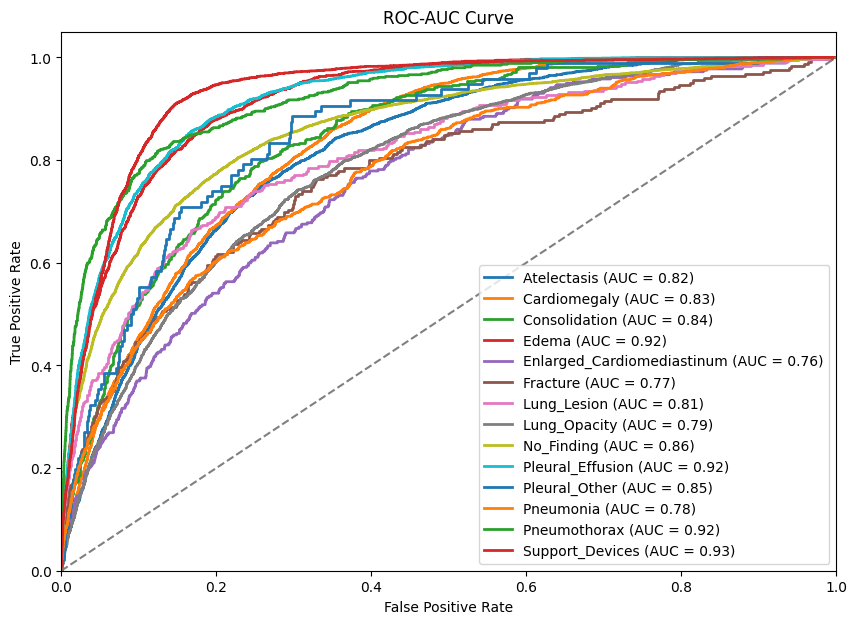

In [ ]:
# Plot ROC-AUC curve for each class
plt.figure(figsize=(10, 7))
for i, label_name in enumerate(labels_Columns):
    fpr, tpr, _ = roc_curve(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

## Binray Classification

* Create a list of thresholds, calculate each threshold's precision, recall, and f1 score, and then return the threshold that produces the highest f1 score all based on validation set.

In [ ]:

def make_pred_multilabel(model, test_dataset, validation_dataset, test_df):

    #Load  pre-trained Keras model
    PRED_LABELS = labels_Columns

    for mode in ["Threshold", "test"]:
        # Create empty dataframes
        #break
        pred_df = pd.DataFrame(columns=["path"])
        bi_pred_df = pd.DataFrame(columns=["path"])
        true_df = pd.DataFrame(columns=["path"])

        if mode == "Threshold":
            data = validation_dataset  # Use validation dataset for threshold mode
            Eval_df = pd.DataFrame(columns=["label", 'bestthr'])
            thrs = []

        if mode == "test":
            data = test_dataset  # Use test dataset for test mode
            index=0
            TestEval_df = pd.DataFrame(columns=["label", 'auc', "auprc","accuracy"])

            Eval = pd.read_csv(prediction_results_path+"/Threshold.csv")  # Load threshold values from the CSV
            Eval.head(14)
            thrs = [Eval["bestthr"][Eval[Eval["label"] == label].index[0]] for label in PRED_LABELS]

            print("thrs :",thrs)

        for inputs, labels in data:
            # Get predictions from the pre-trained model
            inputs = tf.constant(inputs, dtype=tf.float32)
            true_labels = labels.numpy()
            model.set_weights(model.get_weights())

            """ perform inference
              ... use tf.expand_dims(inputs, axis=0) adds an extra dimension at axis 0,
              ... effectively creating a batch of size 1. """

            inputs_batched = tf.expand_dims(inputs, axis=0)
            outputs = model(inputs_batched, training=False)
            probs = outputs.numpy()

            thisrow = {}
            bi_thisrow = {}
            truerow = {}

            # thisrow['path']='path'
            # truerow['path']='path'

            if mode == "test":
              path=test_df.iloc[index]['path']
              bi_thisrow['path']=path

            # Iterate over each entry in prediction vector; each corresponds to an individual label
            for j, _label in enumerate(PRED_LABELS):
                thisrow["prob_" + _label] = probs[0][j]
                truerow[_label] = true_labels[j]

                if mode == "test":
                   bi_thisrow["bi_" + _label] = probs[0][j] >= thrs[j]

            pred_df = pd.concat([pred_df, pd.DataFrame([thisrow])], ignore_index=True)
            true_df = pd.concat([true_df, pd.DataFrame([truerow])], ignore_index=True)

            if mode == "test":
              #Explicitly cast object-dtype columns with boolean values to bool
              bool_columns = [col_name for col_name in bi_pred_df.columns if col_name != 'path'
               and bi_pred_df[col_name].dtype == 'object']
              bi_pred_df[bool_columns] = bi_pred_df[bool_columns].astype(bool)

              #Append the dictionary to the DataFrame
              bi_pred_df = pd.concat([bi_pred_df, pd.DataFrame([bi_thisrow])], ignore_index=True)
              index=index+1



        #print(f'Last indext in thershold : {index}')
        for column in true_df:
          if column not in PRED_LABELS:
            continue
          actual = true_df[column]
          pred = pred_df["prob_" + column]

          thisrow = {}
          thisrow['label'] = column
          if mode == "test":
            bi_pred = bi_pred_df["bi_" + column]
            thisrow['auc'] = np.nan
            thisrow['accuracy'] = np.nan
            thisrow['auprc'] = np.nan
          else:
            thisrow['bestthr'] = np.nan

          try:

            if mode == "test":
              # Calculate the AUC using the true labels and predicted probabilities
              thisrow['auc'] =sklm.roc_auc_score(actual.astype(int),pred)

              thisrow['auprc'] = sklm.average_precision_score(
                  actual.astype(int), pred)

              #Calculate accuracy
              thisrow['accuracy'] = sklm.accuracy_score(actual.astype(int), bi_pred)
            else:

              p, r, t = sklm.precision_recall_curve(actual.astype(int), pred)

              #Calculate F1-score, handling division by zero
              f1_scores = []
              for precision, recall in zip(p, r):
                if precision + recall == 0:
                  f1_scores.append(0.0)  # Handle division by zero
                else:
                  f1_scores.append(2 * (precision * recall) / (precision + recall))

              #Find the threshold that maximizes F1-score
              best_threshold = t[np.argmax(f1_scores)]

              thrs.append(best_threshold)
              thisrow['bestthr'] = best_threshold

          except BaseException as be:
            #Handle the exception
            print(f'can not caclucalte AUC and Accuracy for  : {str(column)}, see the error : {str(be)}')

          if mode == "Threshold":
            Eval_df = pd.concat([Eval_df, pd.DataFrame([thisrow])], ignore_index=True)

          if mode == "test":
            TestEval_df = pd.concat([TestEval_df, pd.DataFrame([thisrow])], ignore_index=True)


        # Save results to CSV

        if mode == "Threshold":
          Eval_df.to_csv(prediction_results_path+"/Threshold.csv", index=False)

        if mode == "test":
          TestEval_df.to_csv(prediction_results_path+"TestEval.csv", index=False)
          bi_pred_df.to_csv(prediction_results_path+"bipred.csv", index=False)


    avg_AUC=TestEval_df['auc'].sum() / 14.0
    avg_accuracy=TestEval_df['accuracy'].sum() / 14.0

    print("AUC ave:", round(avg_AUC,2))
    #print("auprc ave:", TestEval_df['auprc'].sum() / 14.0)
    print("Accuracy ave:", round(avg_accuracy,2))
    print("done")

    #return pred_df, Eval_df, bi_pred_df,TestEval_df


In [ ]:
#path_image = path_to_image_files  # Replace with the path to your image files
make_pred_multilabel(model, test_data,
                                                              validation_data,TrueWithMeta)

/tmp/ipykernel_5882/4078457490.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Eval_df = pd.concat([Eval_df, pd.DataFrame([thisrow])], ignore_index=True)


thrs : [0.22946744, 0.29210296, 0.09968529, 0.21947362, 0.0529065, 0.06825822, 0.095528424, 0.26148236, 0.41139907, 0.2966753, 0.06776675, 0.14419499, 0.14535499, 0.46017003]
AUC ave: 0.84
Accuracy ave: 0.88
done


/tmp/ipykernel_5882/4078457490.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  TestEval_df = pd.concat([TestEval_df, pd.DataFrame([thisrow])], ignore_index=True)


In [ ]:
pred_csv = data_df=pd.read_csv(prediction_results_path+"bipred.csv")
pred_total_columns = len(pred_csv.columns)
pred_df = pred_csv.iloc[:, pred_total_columns - 14:]
pred_df

,bi_Atelectasis,bi_Cardiomegaly,bi_Consolidation,bi_Edema,bi_Enlarged_Cardiomediastinum,bi_Fracture,bi_Lung_Lesion,bi_Lung_Opacity,bi_No_Finding,bi_Pleural_Effusion,bi_Pleural_Other,bi_Pneumonia,bi_Pneumothorax,bi_Support_Devices
0,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,True,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,True,True,False,True,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13569,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13570,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13571,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13572,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [ ]:
true_df = pd.read_csv(prediction_results_path+"TrueWithMeta.csv")
true_df_columns = len(true_df.columns)
true_df_attr = true_df.iloc[:, true_df_columns - 19:true_df_columns - 14]
true_df_attr
pred_df_with_attr = pd.concat([true_df_attr, pred_df], axis=1)
pred_df_with_attr
# true_df_with_attr = csv_reader.iloc[:, true_df_columns - 19:]
# true_df_with_attr
pred_df_with_attr = pred_df_with_attr.drop(pred_df_with_attr.columns[2], axis=1)
pred_df_with_attr


,gender,insurance,age_decile,race,bi_Atelectasis,bi_Cardiomegaly,bi_Consolidation,bi_Edema,bi_Enlarged_Cardiomediastinum,bi_Fracture,bi_Lung_Lesion,bi_Lung_Opacity,bi_No_Finding,bi_Pleural_Effusion,bi_Pleural_Other,bi_Pneumonia,bi_Pneumothorax,bi_Support_Devices
0,F,Medicare,40-60,HISPANIC/LATINO,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,F,Medicaid,20-40,BLACK/AFRICAN AMERICAN,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,M,Other,40-60,WHITE,False,False,False,False,False,True,False,False,True,False,False,False,False,False
3,M,Medicaid,20-40,HISPANIC/LATINO,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,F,Medicare,80+,WHITE,True,True,False,True,False,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13569,M,Medicare,60-80,WHITE,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13570,M,Other,20-40,WHITE,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13571,F,Medicaid,40-60,WHITE,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13572,M,Other,20-40,WHITE,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [ ]:
attribute_list = pred_df_with_attr.columns[-14:].tolist()
true_df_without_attr = true_df.iloc[:, true_df_columns - 14:]
final_df = pd.concat([pred_df_with_attr, true_df_without_attr], axis=1)
group_list = pred_df_with_attr.columns[:4].tolist()
group_list

['gender', 'insurance', 'age_decile', 'race']

In [ ]:
from sklearn.metrics import confusion_matrix
def fprCheck_noFinding(def_df):

  last_label = 'No_Finding'
  fpr_list = []
  temp_predict_prefix = "bi_" + last_label
  temp_true_prefix = last_label
  conf_matrix = confusion_matrix(def_df[temp_true_prefix], def_df[temp_predict_prefix])
  #calculate False Positives for index i
  FP = conf_matrix[0, 1]  # False Positives
  TN = conf_matrix[0, 0]  # True Negatives

  # Calculate FPR
  FPR = FP / (FP + TN)
  #append FPR to the current list
  fpr_list.append(FPR)
  #return the fpr_list
  return fpr_list
new_list = fprCheck_noFinding(final_df)
print(new_list)

[0.21056079664570232]


In [ ]:
import pandas as pd

def group_fpr_cal_noFindings(df,group_list):
  FPR_set = {}
  #use for loop to check all the items in Group_list
  for group_item in group_list:
    FPR_subset = {}
    #generate the unique items from the group_list
    labels_list = df[group_item].unique()
    #use for loop to calcuate FPR
    for label_item in labels_list:
      #create a mask to filter the selected label item
      mask = (df[group_item] == label_item)
      #create dataframe for the mask
      group_df = df[mask]
      # print(label_item)
      FPR_Subgroup = fprCheck_noFinding(group_df)
      FPR_subset[label_item] = FPR_Subgroup
    FPR_set[group_item] = FPR_subset
  return FPR_set
# group_list = ["age_decile","GENDER","Race"]
group_fpr_set = group_fpr_cal_noFindings(final_df,group_list)
print(group_fpr_set)

{'gender': {'F': [0.22511848341232227], 'M': [0.19901315789473684]}, 'insurance': {'Medicare': [0.18920392584514723], 'Medicaid': [0.31467181467181465], 'Other': [0.2176436448055717]}, 'age_decile': {'40-60': [0.25308947108255064], '20-40': [0.3298059964726631], '80+': [0.15820029027576196], '60-80': [0.18823529411764706], '0-20': [0.2222222222222222]}, 'race': {'HISPANIC/LATINO': [0.3546666666666667], 'BLACK/AFRICAN AMERICAN': [0.24766751484308736], 'WHITE': [0.1941603124418821], 'OTHER': [0.21693121693121692], 'ASIAN': [0.18149466192170818], 'AMERICAN INDIAN/ALASKA NATIVE': [0.11904761904761904]}}


The FPR Gap for M in gender is -0.011547638750965483 
The FPR Gap for F in gender is 0.014557686766619948 
The difference in gap is 0.02610532551758543
#############
The FPR Gap for Medicare in insurance is -0.021356870800555094 
The FPR Gap for Other in insurance is 0.0070828481598693704 
The FPR Gap for Medicaid in insurance is 0.10411101802611233 
The difference in gap is 0.12546788882666743
#############
The FPR Gap for 80+ in age_decile is -0.05236050636994036 
The FPR Gap for 60-80 in age_decile is -0.022325502528055263 
The FPR Gap for 0-20 in age_decile is 0.01166142557651989 
The FPR Gap for 40-60 in age_decile is 0.042528674436848324 
The FPR Gap for 20-40 in age_decile is 0.1192451998269608 
The difference in gap is 0.17160570619690116
#############
The FPR Gap for AMERICAN INDIAN/ALASKA NATIVE in race is -0.09151317759808328 
The FPR Gap for ASIAN in race is -0.029066134723994136 
The FPR Gap for WHITE in race is -0.01640048420382023 
The FPR Gap for OTHER in race is 0.0063

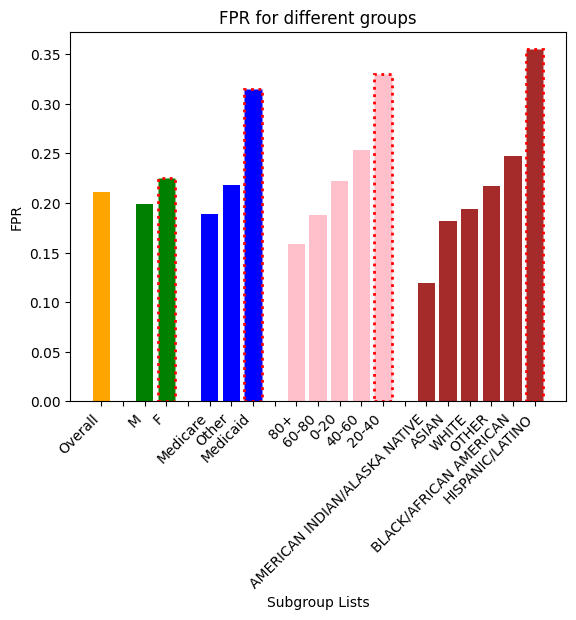

In [ ]:
def fpr_Plot(df,group_list):
  #define colors for different subgroup
  color = {
    'age_decile': 'pink',
    'gender': 'green',
    'race': 'brown',
    'insurance': 'blue',
    'Overall': 'orange'
  }
  #calculate the over fpr and group fpr
  overall_fpr = fprCheck_noFinding(df)
  final_fpr_set = {}
  final_fpr_set["Overall"] = overall_fpr
  group_fpr_set = group_fpr_cal_noFindings(df,group_list)
  final_fpr_set.update(group_fpr_set)
  categories = []
  colors = []
  values = []
  overall_fpr_value = overall_fpr[0]
  fpr_gap_set = {}
  fpr_dis_set = {}
  #put data into the list which will be used for plot
  for group_key,group_value in final_fpr_set.items():
    if group_key == "Overall":
      categories.append(group_key)
      colors.append(color[group_key])
      values.append(group_value[0])
    else:
      fpr_gap = []
      group_items_list = list(group_value.keys())
      current_value_list = []
      current_category_list = []
      current_min = float('inf')
      current_max = -float('inf')
      for group_item in group_items_list:
        current_category_list.append(group_item)
        colors.append(color[group_key])
        current_value = group_value[group_item][0]
        current_value_list.append(current_value)
        current_gap = current_value - overall_fpr_value
        if current_gap > current_max:
          current_max = current_gap
        if current_gap < current_min:
          current_min = current_gap
        fpr_gap.append(current_gap)
        # print(f'The FPR Gap for {group_item} in {group_key} is {current_gap} ')
      indices_sorted = sorted(range(len(current_value_list)), key=lambda index: current_value_list[index])
      ordered_value_list = [current_value_list[i] for i in indices_sorted]
      ordered_fpr_gap = [fpr_gap[i] for i in indices_sorted]
      ordered_category_list = [current_category_list[i] for i in indices_sorted]
      fpr_gap_set[group_key] = ordered_fpr_gap
      values.extend(ordered_value_list)
      #print the FPR for each subgroup
      [print(f'The FPR Gap for {ordered_category_list[index]} in {group_key} is {ordered_fpr_gap[index]} ') for index in range(len(ordered_value_list))]
      gap_dis = current_max - current_min
      fpr_dis_set[group_key] = gap_dis
      print(f'The difference in gap is {gap_dis}')
      categories.extend(ordered_category_list)
      print("#############")
    categories.append('')
    colors.append('white')
    values.append(0)
  categories.pop()
  colors.pop()
  values.pop()
  #plot bar chat and highlight the one with highest fpr
  bar_pos = np.array(range(len(categories)))
  fpr_bars = plt.bar(bar_pos, values, color=colors)
  max_index = 2
  for fpr_gap_key,fpr_gap_value in fpr_gap_set.items():
    # print(fpr_gap_key)
    # print(fpr_gap_value)
    fpr_group_len = len(fpr_gap_value)
    max_subgroup_index = np.argmax(np.array(fpr_gap_value))+ max_index
    print(f'The subgroup - {categories[max_subgroup_index]} suffers most in the group - {fpr_gap_key}')
    fpr_bars[max_subgroup_index].set_edgecolor('red')
    fpr_bars[max_subgroup_index].set_linewidth(2)
    fpr_bars[max_subgroup_index].set_ls('dotted')
    max_index += fpr_group_len + 1
    # print(min_subgroup_index)
  # print(values)
  # Adding labels and title
  plt.xlabel('Subgroup Lists')
  plt.ylabel('FPR')
  plt.title('FPR for different groups')

  # Adding category labels
  plt.xticks(bar_pos, categories, rotation=45, ha='right')
  # Display the chart
  plt.show()
  return fpr_dis_set
  print(fpr_dis_set)



fpr_set = fpr_Plot(final_df,group_list)

In [ ]:
group_fpr_cal_noFindings(final_df,group_list)

{'gender': {'F': [0.22511848341232227], 'M': [0.19901315789473684]},
 'insurance': {'Medicare': [0.18920392584514723],
  'Medicaid': [0.31467181467181465],
  'Other': [0.2176436448055717]},
 'age_decile': {'40-60': [0.25308947108255064],
  '20-40': [0.3298059964726631],
  '80+': [0.15820029027576196],
  '60-80': [0.18823529411764706],
  '0-20': [0.2222222222222222]},
 'race': {'HISPANIC/LATINO': [0.3546666666666667],
  'BLACK/AFRICAN AMERICAN': [0.24766751484308736],
  'WHITE': [0.1941603124418821],
  'OTHER': [0.21693121693121692],
  'ASIAN': [0.18149466192170818],
  'AMERICAN INDIAN/ALASKA NATIVE': [0.11904761904761904]}}

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def generalized_cross_entropy_loss(y_true, y_pred_logits, q=0.7):
    """
    Implements the Generalized Cross Entropy Loss in TensorFlow.
    
    Args:
    - y_true: Tensor of true labels, one-hot encoded, shape [batch_size, num_classes].
    - y_pred_logits: Tensor of predicted logits, shape [batch_size, num_classes].
    - q: Hyperparameter for the loss, controlling the noise robustness.
    
    Returns:
    - The GCE loss, averaged over the batch.
    """
    # Ensure numerical stability with a small epsilon
    epsilon = 1e-9
    
    # Convert logits to probabilities
    y_pred_probs = tf.nn.softmax(y_pred_logits)
    
    # Select the probabilities of the correct classes
    true_probs = tf.reduce_sum(y_true * y_pred_probs, axis=-1)
    
    # Apply the GCE loss formula
    loss = (1 - tf.pow(true_probs + epsilon, q)) / q
    
    # Return the mean loss over the batch
    return tf.reduce_mean(loss)

In [ ]:
# Define a function to build the model
def build_gce_model(
    # hp
    ):

    #Hyperparameters
    # learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    # batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128,256])
    # dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    # weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling='log')
    # hidden_layer_sizes = [hp.Int(f'hidden_{i}', min_value=64, max_value=512, step=64) for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=4))]

    # Define the input layer
    inputs = Input(shape=(embeddings_size,))

    # Build the model using the Functional API
    hidden = inputs
    for size in hidden_layer_sizes:
        hidden = Dense(size,
                       activation='relu',
                       kernel_initializer=HeUniform())(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dropout(dropout)(hidden)

    output = Dense(len(labels_Columns), activation='sigmoid', kernel_initializer=HeUniform())(hidden)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model with AUC as the metric
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=generalized_cross_entropy_loss,
                  metrics=[AUC(multi_label=True)])

    return model

In [ ]:
checkpoint_path = base_path+"/gce_model_checkpoint/"
# Create directory model weightes saving
gce_save_model_dir = os.path.join(checkpoint_path,'models')
os.makedirs(os.path.dirname(gce_save_model_dir), exist_ok=True)

def get_gce_callbacks(patience=5):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             mode="min",
                                             patience=patience,
                                             restore_best_weights=True)
    saved_model = tf.keras.callbacks.ModelCheckpoint(f'{gce_save_model_dir}/model_gce.n5',
                                                monitor='val_auc',
                                                mode='max',
                                                save_freq='epoch',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                verbose=1)
    saved_model = tf.keras.callbacks.ModelCheckpoint(f'{gce_save_model_dir}/model_gce.h5',
                                                    monitor='val_auc',
                                                    mode='max',
                                                    save_freq='epoch',
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    verbose=1)
    callbacks_list = [early_stop,
                      saved_model,
                     ]
    return callbacks_list

In [ ]:
gce_model=build_gce_model()

In [ ]:
# train the model
history=gce_model.fit(
    x=training_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(batch_size).cache(),
    callbacks = get_gce_callbacks(patience=5),
    epochs=50,
)

Epoch 1/50


   3404/Unknown - 8s 2ms/step - loss: 0.9874 - auc: 0.7081
Epoch 1: val_auc improved from -inf to 0.74283, saving model to ./gce_model_checkpoint/models/model_gce.h5
3405/3405 [==============================] - 9s 2ms/step - loss: 0.9874 - auc: 0.7082 - val_loss: 0.9707 - val_auc: 0.7428
Epoch 2/50
  82/3405 [..............................] - ETA: 6s - loss: 0.9720 - auc: 0.7226

/home/cywang14/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3391/3405 [============================>.] - ETA: 0s - loss: 0.9674 - auc: 0.7209
Epoch 2: val_auc did not improve from 0.74283
3405/3405 [==============================] - 5s 2ms/step - loss: 0.9674 - auc: 0.7209 - val_loss: 0.9672 - val_auc: 0.7171
Epoch 3/50
3399/3405 [============================>.] - ETA: 0s - loss: 0.9658 - auc: 0.7106
Epoch 3: val_auc did not improve from 0.74283
3405/3405 [==============================] - 5s 2ms/step - loss: 0.9658 - auc: 0.7106 - val_loss: 0.9665 - val_auc: 0.7162
Epoch 4/50
3395/3405 [============================>.] - ETA: 0s - loss: 0.9648 - auc: 0.7077
Epoch 4: val_auc did not improve from 0.74283
3405/3405 [==============================] - 5s 2ms/step - loss: 0.9648 - auc: 0.7078 - val_loss: 0.9657 - val_auc: 0.7096
Epoch 5/50
3376/3405 [============================>.] - ETA: 0s - loss: 0.9644 - auc: 0.7080
Epoch 5: val_auc did not improve from 0.74283
3405/3405 [==============================] - 5s 2ms/step - loss: 0.9644 - auc: 0.7080 

In [ ]:
print('======== Loading saved model ========================')
gce_model.load_weights(f'{gce_save_model_dir}/model_gce.h5')

======== Loading saved model ========================


In [ ]:
# y_pred_prob = model.predict(test_data.batch(32))
# losses = []
# import math
# for i, y_pred in enumerate(y_pred_prob):
#     print(y_pred[8])
# for batch in training_data:
#     # Extract the last numpy array
#     last_numpy_array = np.array(batch[1])

#     # Print the last numpy array
#     print(last_numpy_array)
gce_predict_result = gce_model.predict(training_data.batch(32))
# print(loss[0])

# print("Loss on testing data:", loss)
gce_predict_result

      1/Unknown - 0s 56ms/step

3405/3405 [==============================] - 6s 2ms/step


array([[9.9716055e-01, 9.9367845e-01, 3.1362162e-03, ..., 1.1623518e-03,
        6.6511094e-04, 9.9931800e-01],
       [9.9840349e-01, 2.9778168e-01, 3.3547080e-03, ..., 3.9114971e-02,
        1.2337425e-02, 1.5380415e-01],
       [3.5801604e-01, 8.6402726e-01, 4.1687596e-03, ..., 8.8163456e-03,
        2.6414627e-02, 9.9995756e-01],
       ...,
       [5.5493647e-03, 1.7418940e-01, 1.9420665e-03, ..., 2.4306297e-01,
        2.7082220e-03, 1.2140604e-01],
       [9.8971510e-01, 9.7322619e-01, 5.3177839e-03, ..., 1.8529344e-02,
        2.1136219e-02, 9.9999744e-01],
       [9.9994308e-01, 6.1682057e-01, 3.6008237e-03, ..., 1.0711683e-01,
        4.0155225e-02, 1.0947682e-01]], dtype=float32)

In [ ]:
import math
loss =[]
for index,batch in enumerate(training_data):
    # Extract the last numpy array
    train_result = np.array(batch[1])
    # print(gce_predict_result[index][8])
    # print(train_result[8])
    # Print the last numpy array
    loss.append(math.fabs(gce_predict_result[index][8] - train_result[8]))

In [ ]:
# len(loss)
df_train_col = df_train.columns.size
gce_df_train = df_train
# gce_df_train = gce_df_train.drop(gce_df_train.columns[2], axis=1)
gce_df_train

,Unnamed: 0,path,subject_id,study_id,dicom_id,split,gender,insurance,anchor_age,age_decile,...,Enlarged_Cardiomediastinum,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices
0,21923,./Extracted_Embeddings/generalized-image-embed...,10930646,52104503,038a3394-8fd03a8d-333ea74e-69be1b2a-91403987,train,F,Medicare,87,80+,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,204876,./Extracted_Embeddings/generalized-image-embed...,18424207,51287260,b58b183e-f0bf25b5-d07d7c18-1855629a-e46b4101,train,M,Medicare,91,80+,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,63733,./Extracted_Embeddings/generalized-image-embed...,12621660,51833966,088e6d23-dda0ff9e-c8647c10-15d2efdc-15d15b96,train,M,Medicare,53,40-60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,96289,./Extracted_Embeddings/generalized-image-embed...,13964931,57456462,4a53bef2-7e7fed7b-cb9bff37-441ccbb7-2b71fd08,train,F,Medicare,77,60-80,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,7252,./Extracted_Embeddings/generalized-image-embed...,10301415,53038472,077a23ab-9883c1a9-0f265acf-5f085bce-600a241e,train,F,Other,79,60-80,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136456,179478,./Extracted_Embeddings/generalized-image-embed...,17369903,57813363,80729c82-38815e83-0ca02f70-d6dbe14c-2accfaca,train,F,Other,26,20-40,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
136457,99388,./Extracted_Embeddings/generalized-image-embed...,14088566,51744141,f00e19ca-692fd4ea-9f522dc2-0061e5a2-0d0ed705,train,F,Other,29,20-40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136458,165040,./Extracted_Embeddings/generalized-image-embed...,16789054,54459255,5b347e46-93723ec9-81e5bb9e-36278dac-68c08679,train,F,Other,86,80+,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
136459,171349,./Extracted_Embeddings/generalized-image-embed...,17049635,53221234,0c304400-cef8af5f-ef256860-b8240568-43720341,train,M,Other,60,60-80,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
list_df = pd.DataFrame([loss], columns=gce_df_train.index)
list_df = list_df.T
list_df.rename(columns={0: 'loss'}, inplace=True)
df = pd.concat([gce_df_train, list_df], axis=1)
df


,Unnamed: 0,path,subject_id,study_id,dicom_id,split,gender,insurance,anchor_age,age_decile,...,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices,loss
0,21923,./Extracted_Embeddings/generalized-image-embed...,10930646,52104503,038a3394-8fd03a8d-333ea74e-69be1b2a-91403987,train,F,Medicare,87,80+,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000187
1,204876,./Extracted_Embeddings/generalized-image-embed...,18424207,51287260,b58b183e-f0bf25b5-d07d7c18-1855629a-e46b4101,train,M,Medicare,91,80+,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.960362
2,63733,./Extracted_Embeddings/generalized-image-embed...,12621660,51833966,088e6d23-dda0ff9e-c8647c10-15d2efdc-15d15b96,train,M,Medicare,53,40-60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.041330
3,96289,./Extracted_Embeddings/generalized-image-embed...,13964931,57456462,4a53bef2-7e7fed7b-cb9bff37-441ccbb7-2b71fd08,train,F,Medicare,77,60-80,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.001517
4,7252,./Extracted_Embeddings/generalized-image-embed...,10301415,53038472,077a23ab-9883c1a9-0f265acf-5f085bce-600a241e,train,F,Other,79,60-80,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136456,179478,./Extracted_Embeddings/generalized-image-embed...,17369903,57813363,80729c82-38815e83-0ca02f70-d6dbe14c-2accfaca,train,F,Other,26,20-40,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000292
136457,99388,./Extracted_Embeddings/generalized-image-embed...,14088566,51744141,f00e19ca-692fd4ea-9f522dc2-0061e5a2-0d0ed705,train,F,Other,29,20-40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.994849
136458,165040,./Extracted_Embeddings/generalized-image-embed...,16789054,54459255,5b347e46-93723ec9-81e5bb9e-36278dac-68c08679,train,F,Other,86,80+,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103644
136459,171349,./Extracted_Embeddings/generalized-image-embed...,17049635,53221234,0c304400-cef8af5f-ef256860-b8240568-43720341,train,M,Other,60,60-80,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.093208


In [ ]:
def check_size(df,group_list):
    for group_item in group_list:
    #generate the unique items from the group_list
        labels_list = df[group_item].unique()
        print(group_item)
    #use for loop to calcuate FPR
        for label_item in labels_list:
            #create a mask to filter the selected label item
            mask = (df[group_item] == label_item)
            #create dataframe for the mask
            group_df = df[mask]
            print(group_df.shape[0])
#   return FPR_set
age_list = ['age_decile']
check_size(df,age_list)

age_decile
16300
34919
44471
12704
558


In [ ]:
#  Old top k for one age
#  def top_k_gce(df,group_list):
#     new_df_list = []
#     for group_item in group_list:
#     #generate the unique items from the group_list
#         labels_list = df[group_item].unique()
#         print(group_item)
#     #use for loop to calcuate FPR
#         for label_item in labels_list:
#             #create a mask to filter the selected label item
#             mask = (df[group_item] == label_item)
#             #create dataframe for the mask
#             group_df = df[mask]
#             group_df_sorted = group_df.sort_values(by='loss')

#             # print(group_df_sorted.shape[0])
#             group_size = group_df_sorted.shape[0]
#             group_portion = group_size/df.shape[0]
#             group_percent = group_portion/(1-group_portion)
#             # print(group_portion)
#             # print(group_portion/(1-group_portion))
#             if group_percent > 0.25:
#                 number_reduction = int(group_size*0.2*(math.exp(group_percent)/(3+ math.exp(group_percent))))
#                 print(number_reduction)
#                 df_trimmed = group_df_sorted.iloc[number_reduction:]
#                 new_df_list.append(df_trimmed)
#                 # print(df_trimmed.shape)
#             else:
#                 new_df_list.append(group_df_sorted)
#             # print(group_df_sorted.shape[0])
#             # print(len(new_df_list[0]))
#     new_df = pd.concat(new_df_list, ignore_index=True)
#     # print(new_df.shape)
#     return new_df
# age_list = ['age_decile']
# new_train_df = top_k_gce(df,age_list)
# new_train_df


In [ ]:
df

,Unnamed: 0,path,subject_id,study_id,dicom_id,split,gender,insurance,anchor_age,age_decile,...,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices,loss
0,21923,./Extracted_Embeddings/generalized-image-embed...,10930646,52104503,038a3394-8fd03a8d-333ea74e-69be1b2a-91403987,train,F,Medicare,87,80+,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000187
1,204876,./Extracted_Embeddings/generalized-image-embed...,18424207,51287260,b58b183e-f0bf25b5-d07d7c18-1855629a-e46b4101,train,M,Medicare,91,80+,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.960362
2,63733,./Extracted_Embeddings/generalized-image-embed...,12621660,51833966,088e6d23-dda0ff9e-c8647c10-15d2efdc-15d15b96,train,M,Medicare,53,40-60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.041330
3,96289,./Extracted_Embeddings/generalized-image-embed...,13964931,57456462,4a53bef2-7e7fed7b-cb9bff37-441ccbb7-2b71fd08,train,F,Medicare,77,60-80,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.001517
4,7252,./Extracted_Embeddings/generalized-image-embed...,10301415,53038472,077a23ab-9883c1a9-0f265acf-5f085bce-600a241e,train,F,Other,79,60-80,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136456,179478,./Extracted_Embeddings/generalized-image-embed...,17369903,57813363,80729c82-38815e83-0ca02f70-d6dbe14c-2accfaca,train,F,Other,26,20-40,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000292
136457,99388,./Extracted_Embeddings/generalized-image-embed...,14088566,51744141,f00e19ca-692fd4ea-9f522dc2-0061e5a2-0d0ed705,train,F,Other,29,20-40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.994849
136458,165040,./Extracted_Embeddings/generalized-image-embed...,16789054,54459255,5b347e46-93723ec9-81e5bb9e-36278dac-68c08679,train,F,Other,86,80+,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.103644
136459,171349,./Extracted_Embeddings/generalized-image-embed...,17049635,53221234,0c304400-cef8af5f-ef256860-b8240568-43720341,train,M,Other,60,60-80,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.093208


In [425]:
from sklearn.utils import shuffle
def top_k_gce(df,group_list,frp_dis_grp):
    new_df = df
    group_fpr = group_fpr_cal_noFindings(final_df, group_list)
    over_all_fpr = fprCheck_noFinding(final_df)
    
    for group_item in group_list:
        new_df_list = []
        print(group_item)
    #generate the unique items from the group_list
        labels_list = new_df[group_item].unique()
    #use for loop to calcuate FPR
        for label_item in labels_list:
            if group_fpr[group_item][label_item][0] > over_all_fpr:
                continue
            #create a mask to filter the selected label item
            mask = (new_df[group_item] == label_item)
            #create dataframe for the mask
            group_df = new_df[mask]
            group_df_sorted = group_df.sort_values(by='loss')
            # group_df_sorted = group_df
            # print(group_df_sorted.shape[0])
            group_size = group_df_sorted.shape[0]
            group_portion = group_size/new_df.shape[0]
            group_percent = group_portion/(1-group_portion)
            # print(group_portion)
            # print(group_portion/(1-group_portion))
            if group_percent > 0.15:
                weight = fpr_dis_grp[group_item]
                weight_cal = math.exp(10*weight/(1-weight))
                final_weight = weight_cal/(1+weight_cal)
                # print(final_weight)
                number_reduction = int(group_size*0.05*final_weight*(math.exp(group_percent)/(3+ math.exp(group_percent))))
                # print(number_reduction)
                percentage_to_remove = 1
                top_k_remove = int(percentage_to_remove*number_reduction)
                df_trimmed = group_df_sorted.iloc[top_k_remove:]
                # num_rows_to_remove = int(number_reduction - top_k_remove)
                # rows_to_remove = np.random.choice(df_trimmed.index, size=num_rows_to_remove, replace=False)
                # Drop the selected rows
                # df_trimmed = df_trimmed.drop(rows_to_remove)
                new_df_list.append(df_trimmed)
                # print(df_trimmed.shape)
            # elif group_percent < 0.053:
            #     num_rows_to_add = int(0.2 * len(group_df_sorted))
            #     # rows_to_remove = np.random.choice(group_df_sorted.index, size=num_rows_to_add, replace=False)
            #     upsampled_class = group_df_sorted.sample(num_rows_to_add, replace=True)
            #     df_upsampled = pd.concat([group_df_sorted] + [upsampled_class])
            #     # print(num_rows_to_add)
            #     new_df_list.append(df_upsampled)
            else:
                new_df_list.append(group_df_sorted)
            # print(group_df_sorted.shape[0])
            # print(len(new_df_list[0]))
        new_df = pd.concat(new_df_list, ignore_index=True)
        print(new_df.shape)
    shuff_df = shuffle(new_df)
    return shuff_df
sub_list = ['gender', 'insurance', 'age_decile', 'race']
# sub_list = ['insurance', 'age_decile', 'race']
fpr_dis_grp = fpr_set
new_train_df = top_k_gce(df,sub_list,fpr_dis_grp)
fpr_dis_grp


gender
(56128, 26)
insurance
(23043, 26)
age_decile
(17450, 26)
race
(13928, 26)


{'gender': 0.02610532551758543,
 'insurance': 0.12546788882666743,
 'age_decile': 0.17160570619690116,
 'race': 0.23561904761904764}

In [426]:
group_fpr_set = group_fpr_cal_noFindings(final_df,group_list)
print(group_fpr_set)
over_all_fpr = fprCheck_noFinding(final_df)

{'gender': {'F': [0.22511848341232227], 'M': [0.19901315789473684]}, 'insurance': {'Medicare': [0.18920392584514723], 'Medicaid': [0.31467181467181465], 'Other': [0.2176436448055717]}, 'age_decile': {'40-60': [0.25308947108255064], '20-40': [0.3298059964726631], '80+': [0.15820029027576196], '60-80': [0.18823529411764706], '0-20': [0.2222222222222222]}, 'race': {'HISPANIC/LATINO': [0.3546666666666667], 'BLACK/AFRICAN AMERICAN': [0.24766751484308736], 'WHITE': [0.1941603124418821], 'OTHER': [0.21693121693121692], 'ASIAN': [0.18149466192170818], 'AMERICAN INDIAN/ALASKA NATIVE': [0.11904761904761904]}}


In [427]:
def top_k_gce_up_down_sampling(df, gs_fpr, overall):
    final_df = top_k_gce(df, group_list, fpr_dis_grp)
    new_df = df.sort_values(by='loss')
    for group in gs_fpr:
        print(group)
        for t in gs_fpr[group]:
            if gs_fpr[group][t][0] > over_all_fpr[0]:

                group_df = new_df[df[group] == t]
                final_df = pd.concat([final_df, group_df[:int(len(group_df)//4)]])
    return final_df
new_train_df = top_k_gce_up_down_sampling(df, group_fpr_set, over_all_fpr)

gender
(56128, 26)
insurance
(23043, 26)
age_decile
(17450, 26)
race
(13928, 26)
gender
insurance
age_decile
race


/tmp/ipykernel_5882/1528060124.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_df = new_df[df[group] == t]
/tmp/ipykernel_5882/1528060124.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_df = new_df[df[group] == t]
/tmp/ipykernel_5882/1528060124.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_df = new_df[df[group] == t]
/tmp/ipykernel_5882/1528060124.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_df = new_df[df[group] == t]
/tmp/ipykernel_5882/1528060124.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_df = new_df[df[group] == t]
/tmp/ipykernel_5882/1528060124.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group_df = new_df[df[group] == t]
/tmp/ipykernel_5882/1528060124.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame 

In [428]:
# def top_k_gce_down_sampling(df, gs_fpr, overall):
#     final_df = top_k_gce(df, group_list, fpr_dis_grp)
#     return final_df
#     new_df = df.sort_values(by='loss')
#     for group in gs_fpr:
#         print(group)
#         for t in gs_fpr[group]:
#             if gs_fpr[group][t][0] > over_all_fpr[0]:

#                 group_df = new_df[df[group] == t]
#                 final_df = pd.concat([final_df, group_df[:int(len(group_df)//5)]])
#     return final_df
# new_train_df = top_k_gce_down_sampling(df, group_fpr_set, over_all_fpr)

In [429]:
# def top_k_gce_up_sampling(df, gs_fpr, overall):
#     final_df = df
#     new_df = df.sort_values(by='loss')
#     for group in gs_fpr:
#         # if group != 'gender':
#         #     continue
#         print(group)
#         for t in gs_fpr[group]:
#             if gs_fpr[group][t][0] > over_all_fpr[0]:

#                 group_df = new_df[df[group] == t]
#                 final_df = pd.concat([final_df, group_df[:int(len(group_df)//5)]])
#     return final_df
# new_train_df = top_k_gce_up_sampling(df, group_fpr_set, over_all_fpr)

In [430]:
new_train_df = new_train_df.drop("loss", axis=1)
new_train_df

,Unnamed: 0,path,subject_id,study_id,dicom_id,split,gender,insurance,anchor_age,age_decile,...,Enlarged_Cardiomediastinum,Fracture,Lung_Lesion,Lung_Opacity,No_Finding,Pleural_Effusion,Pleural_Other,Pneumonia,Pneumothorax,Support_Devices
11443,79330,./Extracted_Embeddings/generalized-image-embed...,13269006,52693962,b10678fe-7eb83de8-df85b09d-e56566cd-77ca8153,train,M,Medicare,81,80+,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3067,46353,./Extracted_Embeddings/generalized-image-embed...,11919347,50764074,d1814549-1b029c69-fea7cab9-6480a955-b93e7dfd,train,M,Medicare,77,60-80,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9643,102603,./Extracted_Embeddings/generalized-image-embed...,14215082,54817404,8204754e-d33fea74-d9d8556e-08545589-e6e57a3a,train,M,Medicare,79,60-80,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6502,203181,./Extracted_Embeddings/generalized-image-embed...,18343701,50985249,dc515ed9-bf51dbc5-849437e7-dba82757-52e90de6,train,M,Medicare,83,80+,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
13354,183515,./Extracted_Embeddings/generalized-image-embed...,17536303,50604925,a4ba737f-62cc52d1-f7694fa9-b149a4a2-a634ad60,train,M,Medicare,75,60-80,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16766,182089,./Extracted_Embeddings/generalized-image-embed...,17471754,52290861,c6a7e7c8-e7908cdd-8a097a5c-8d5929ae-e17b2b01,train,M,Other,23,20-40,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
105112,63672,./Extracted_Embeddings/generalized-image-embed...,12620123,55528124,af273fb6-12514f7c-5b385333-f5df5b78-12aa02d8,train,M,Medicare,75,60-80,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
36991,29751,./Extracted_Embeddings/generalized-image-embed...,11255143,50941783,a770d8d6-7b6a62ff-815ab876-c81709a8-9a654a54,train,F,Other,24,20-40,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
60762,37736,./Extracted_Embeddings/generalized-image-embed...,11580826,51984435,4661df0f-c5760e65-6d957f9a-5cd78a96-abcff279,train,M,Other,62,60-80,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [431]:
new_training_data = embeddings_data.get_dataset(filenames=new_train_df.path.values,
                        labels=new_train_df[labels_Columns].values)


In [432]:
tf.keras.backend.clear_session()

In [433]:
def build__new_model(
    # hp
    ):

    #Hyperparameters
    # learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    # batch_size = hp.Choice('batch_size', values=[16, 32, 64, 128,256])
    # dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    # weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-3, sampling='log')
    # hidden_layer_sizes = [hp.Int(f'hidden_{i}', min_value=64, max_value=512, step=64) for i in range(hp.Int('num_hidden_layers', min_value=1, max_value=4))]

    # Define the input layer
    inputs = Input(shape=(embeddings_size,))

    # Build the model using the Functional API
    hidden = inputs
    for size in hidden_layer_sizes:
        hidden = Dense(size,
                       activation='relu',
                       kernel_initializer=HeUniform())(hidden)
        hidden = BatchNormalization()(hidden)
        hidden = Dropout(dropout)(hidden)

    output = Dense(len(labels_Columns), activation='sigmoid', kernel_initializer=HeUniform())(hidden)

    # Create the model
    model = Model(inputs=inputs, outputs=output)

    # Compile the model with AUC as the metric
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[AUC(multi_label=True)])

    return model

In [434]:
new_checkpoint_path = base_path+"/new_model_checkpoint/"
# Create directory model weightes saving
new_save_model_dir = os.path.join(new_checkpoint_path,'models')
os.makedirs(os.path.dirname(new_save_model_dir), exist_ok=True)

def new_get_callbacks(patience=5):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                             mode="min",
                                             patience=patience,
                                             restore_best_weights=True)
    saved_model = tf.keras.callbacks.ModelCheckpoint(f'{new_save_model_dir}/model.n5',
                                                monitor='val_auc',
                                                mode='max',
                                                save_freq='epoch',
                                                save_best_only=True,
                                                save_weights_only=False,
                                                verbose=1)
    saved_model = tf.keras.callbacks.ModelCheckpoint(f'{new_save_model_dir}/model.h5',
                                                    monitor='val_auc',
                                                    mode='max',
                                                    save_freq='epoch',
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    verbose=1)
    callbacks_list = [early_stop,
                      saved_model,
                     ]
    return callbacks_list

In [435]:
model=build__new_model()

In [436]:
history=model.fit(
    x=new_training_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
    validation_data=validation_data.batch(batch_size).cache(),
    callbacks = new_get_callbacks(patience=5),
    epochs=50,
)

Epoch 1/50


   1923/Unknown - 3s 2ms/step - loss: 0.3324 - auc: 0.7926
Epoch 1: val_auc improved from -inf to 0.76561, saving model to ./new_model_checkpoint/models/model.h5
1949/1949 [==============================] - 4s 2ms/step - loss: 0.3295 - auc: 0.7928 - val_loss: 0.2858 - val_auc: 0.7656
Epoch 2/50
 149/1949 [=>............................] - ETA: 1s - loss: 0.3994 - auc: 0.6890

/home/cywang14/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1935/1949 [============================>.] - ETA: 0s - loss: 0.1570 - auc: 0.8451
Epoch 2: val_auc improved from 0.76561 to 0.77579, saving model to ./new_model_checkpoint/models/model.h5
1949/1949 [==============================] - 2s 1ms/step - loss: 0.1565 - auc: 0.8458 - val_loss: 0.2802 - val_auc: 0.7758
Epoch 3/50
1904/1949 [============================>.] - ETA: 0s - loss: 0.1514 - auc: 0.8493
Epoch 3: val_auc improved from 0.77579 to 0.77903, saving model to ./new_model_checkpoint/models/model.h5
1949/1949 [==============================] - 2s 1ms/step - loss: 0.1507 - auc: 0.8509 - val_loss: 0.2844 - val_auc: 0.7790
Epoch 4/50
1932/1949 [============================>.] - ETA: 0s - loss: 0.1481 - auc: 0.8579
Epoch 4: val_auc did not improve from 0.77903
1949/1949 [==============================] - 2s 1ms/step - loss: 0.1475 - auc: 0.8586 - val_loss: 0.2827 - val_auc: 0.7746
Epoch 5/50
1902/1949 [============================>.] - ETA: 0s - loss: 0.1467 - auc: 0.8594
Epoch 5: val

In [437]:
print('======== Loading saved model ========================')
model.load_weights(f'{new_save_model_dir}/model.h5')

======== Loading saved model ========================


In [438]:
# Set the learning phase to inference mode
tf.keras.backend.set_learning_phase(False)

/home/cywang14/.local/lib/python3.10/site-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [439]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Evaluate using ROC-AUC
y_pred_prob = model.predict(test_data.batch(batch_size))
#dict(zip(model.metrics_names, y_pred_prob))
y_pred_prob[0]

     73/Unknown - 0s 1ms/step

425/425 [==============================] - 1s 1ms/step


array([3.9106347e-03, 4.9660704e-03, 1.6535532e-03, 3.1781814e-03,
       2.0694428e-03, 2.5160045e-03, 1.3729124e-03, 4.1543534e-03,
       9.9236280e-01, 4.6379874e-03, 8.0812979e-04, 1.4970318e-03,
       1.8559678e-03, 1.3044024e-03], dtype=float32)

In [440]:
roc_auc_scores = []
for i in range(14):
    roc_auc = roc_auc_score(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc_scores.append(roc_auc)

average_roc_auc = np.mean(roc_auc_scores)
print("Average ROC-AUC:", round(average_roc_auc,2))

Average ROC-AUC: 0.79


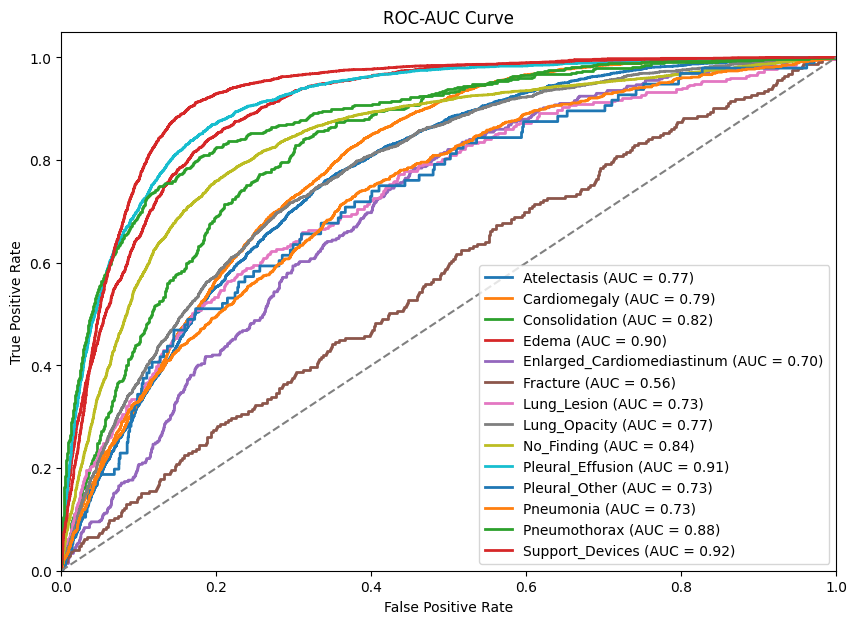

In [441]:
# Plot ROC-AUC curve for each class
plt.figure(figsize=(10, 7))
for i, label_name in enumerate(labels_Columns):
    fpr, tpr, _ = roc_curve(df_test[labels_Columns].values[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{label_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc="lower right")
plt.show()

In [442]:
#path_image = path_to_image_files  # Replace with the path to your image files
make_pred_multilabel(model, test_data,
                                                              validation_data,TrueWithMeta)

/tmp/ipykernel_5882/4078457490.py:128: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Eval_df = pd.concat([Eval_df, pd.DataFrame([thisrow])], ignore_index=True)


thrs : [0.092167474, 0.08471531, 0.0742256, 0.2822089, 0.01846649, 0.021436196, 0.032792397, 0.0795911, 0.7053821, 0.325009, 0.020431291, 0.07481762, 0.16038644, 0.2021098]
AUC ave: 0.79
Accuracy ave: 0.84
done


/tmp/ipykernel_5882/4078457490.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  TestEval_df = pd.concat([TestEval_df, pd.DataFrame([thisrow])], ignore_index=True)


In [443]:
pred_csv = data_df=pd.read_csv(prediction_results_path+"bipred.csv")
pred_total_columns = len(pred_csv.columns)
pred_df = pred_csv.iloc[:, pred_total_columns - 14:]
pred_df

,bi_Atelectasis,bi_Cardiomegaly,bi_Consolidation,bi_Edema,bi_Enlarged_Cardiomediastinum,bi_Fracture,bi_Lung_Lesion,bi_Lung_Opacity,bi_No_Finding,bi_Pleural_Effusion,bi_Pleural_Other,bi_Pneumonia,bi_Pneumothorax,bi_Support_Devices
0,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,True,True,False,True,True,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13569,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13570,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13571,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13572,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [444]:
true_df = pd.read_csv(prediction_results_path+"TrueWithMeta.csv")
true_df_columns = len(true_df.columns)
true_df_attr = true_df.iloc[:, true_df_columns - 19:true_df_columns - 14]
true_df_attr
pred_df_with_attr = pd.concat([true_df_attr, pred_df], axis=1)
pred_df_with_attr
# true_df_with_attr = csv_reader.iloc[:, true_df_columns - 19:]
# true_df_with_attr
pred_df_with_attr = pred_df_with_attr.drop(pred_df_with_attr.columns[2], axis=1)
pred_df_with_attr


,gender,insurance,age_decile,race,bi_Atelectasis,bi_Cardiomegaly,bi_Consolidation,bi_Edema,bi_Enlarged_Cardiomediastinum,bi_Fracture,bi_Lung_Lesion,bi_Lung_Opacity,bi_No_Finding,bi_Pleural_Effusion,bi_Pleural_Other,bi_Pneumonia,bi_Pneumothorax,bi_Support_Devices
0,F,Medicare,40-60,HISPANIC/LATINO,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,F,Medicaid,20-40,BLACK/AFRICAN AMERICAN,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,M,Other,40-60,WHITE,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,M,Medicaid,20-40,HISPANIC/LATINO,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,F,Medicare,80+,WHITE,True,True,False,True,True,False,False,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13569,M,Medicare,60-80,WHITE,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13570,M,Other,20-40,WHITE,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13571,F,Medicaid,40-60,WHITE,False,False,False,False,False,False,False,False,True,False,False,False,False,False
13572,M,Other,20-40,WHITE,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [445]:
attribute_list = pred_df_with_attr.columns[-14:].tolist()
true_df_without_attr = true_df.iloc[:, true_df_columns - 14:]
final_df_after_change = pd.concat([pred_df_with_attr, true_df_without_attr], axis=1)
group_list = pred_df_with_attr.columns[:4].tolist()
group_list

['gender', 'insurance', 'age_decile', 'race']

In [446]:
from sklearn.metrics import confusion_matrix
def fprCheck_noFinding(def_df):

  last_label = 'No_Finding'
  fpr_list = []
  temp_predict_prefix = "bi_" + last_label
  temp_true_prefix = last_label
  conf_matrix = confusion_matrix(def_df[temp_true_prefix], def_df[temp_predict_prefix])
  #calculate False Positives for index i
  FP = conf_matrix[0, 1]  # False Positives
  TN = conf_matrix[0, 0]  # True Negatives

  # Calculate FPR
  FPR = FP / (FP + TN)
  #append FPR to the current list
  fpr_list.append(FPR)
  #return the fpr_list
  return fpr_list
new_list = fprCheck_noFinding(final_df_after_change)
print(new_list)

[0.2557651991614256]


In [447]:
import pandas as pd

def group_fpr_cal_noFindings(df,group_list):
  FPR_set = {}
  #use for loop to check all the items in Group_list
  for group_item in group_list:
    FPR_subset = {}
    #generate the unique items from the group_list
    labels_list = df[group_item].unique()
    #use for loop to calcuate FPR
    for label_item in labels_list:
      #create a mask to filter the selected label item
      mask = (df[group_item] == label_item)
      #create dataframe for the mask
      group_df = df[mask]
      # print(label_item)
      FPR_Subgroup = fprCheck_noFinding(group_df)
      FPR_subset[label_item] = FPR_Subgroup
    FPR_set[group_item] = FPR_subset
  return FPR_set
# group_list = ["age_decile","GENDER","Race"]
group_fpr_set = group_fpr_cal_noFindings(final_df_after_change,group_list)
print(group_fpr_set)

{'gender': {'F': [0.2710308056872038], 'M': [0.243656015037594]}, 'insurance': {'Medicare': [0.24427480916030533], 'Medicaid': [0.33976833976833976], 'Other': [0.2553685432385374]}, 'age_decile': {'40-60': [0.28077113198220466], '20-40': [0.3262786596119929], '80+': [0.2351233671988389], '60-80': [0.23885088919288647], '0-20': [0.2222222222222222]}, 'race': {'HISPANIC/LATINO': [0.37333333333333335], 'BLACK/AFRICAN AMERICAN': [0.3053435114503817], 'WHITE': [0.2404686628231356], 'OTHER': [0.24867724867724866], 'ASIAN': [0.20284697508896798], 'AMERICAN INDIAN/ALASKA NATIVE': [0.19047619047619047]}}


[0 1]
gender M
gender F
5
[0 1 2]
insurance Medicare
insurance Other
insurance Medicaid
9
[0 1 2 3 4]
age_decile 80+
age_decile 60-80
age_decile 0-20
age_decile 40-60
age_decile 20-40
15
[0 1 2 3 4 5]
race AMERICAN INDIAN/ALASKA NATIVE
race ASIAN
race WHITE
race OTHER
race BLACK/AFRICAN AMERICAN
race HISPANIC/LATINO
22
['overall fpr', 'M', 'F', 'Medicare', 'Other', 'Medicaid', '80+', '60-80', '0-20', '40-60', '20-40', 'AMERICAN INDIAN/ALASKA NATIVE', 'ASIAN', 'WHITE', 'OTHER', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO']


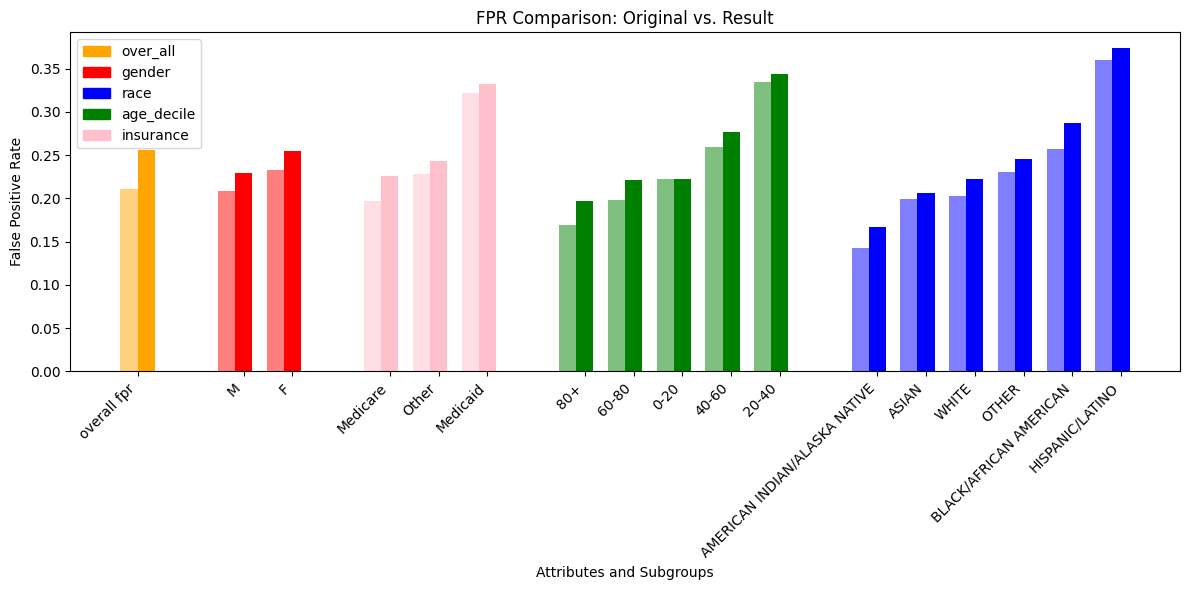

In [453]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches

# Sample data: Original and Result FPRs for different attributes
original_fpr = group_fpr_cal_noFindings(final_df, group_list)
# result_fpr = {key: dict(sorted(value.items(), key=lambda item: item[1])) for key, value in group_fpr_cal_noFindings(final_df_after_change, group_list).items()}
# gaps = []
# new_result_fpr = {}
# for group in result_fpr:
#     fprs = []
#     new_result_fpr[group] = {}
#     new_result_fpr[group]["items"] = {}
#     for label in result_fpr[group]:
#         fprs.append(result_fpr[group][label][0])
#         new_result_fpr[group]["items"][label] = result_fpr[group][label]
#     gap = max(fprs) - min(fprs)
#     new_result_fpr[group]["gap"] = gap
# sorted_data = dict(sorted(new_result_fpr.items(), key=lambda item: item[1]['gap']))
# result_fpr = {}

# for group in sorted_data:
#     result_fpr[group] = {}
#     for label in sorted_data[group]["items"]:
#         result_fpr[group][label] = sorted_data[group]["items"][label]
# print(result_fpr)


# # Combining the data into a DataFrame for plotting
# attributes = []
# subgroups = []
# original_values = []
# result_values = []

# for attribute, subgroup_values in original_fpr.items():
#     for subgroup, value in subgroup_values.items():
#         attributes.append(attribute)
#         subgroups.append(subgroup)
#         original_values.append(value[0])
        
#         result_values.append(result_fpr[attribute][subgroup][0])

data_to_plot = {'gender': {'M': [0.22932330827067668, 0.20864661654135339], 'F': [0.254739336492891, 0.23311611374407584]}, 'insurance': {'Medicare': [0.22546346782988005, 0.19683751363140675], 'Other': [0.242890307603018, 0.2280905397562391], 'Medicaid': [0.33204633204633205, 0.3223938223938224]}, 'age_decile': {'80+': [0.19666182873730043, 0.16981132075471697], '60-80': [0.2213406292749658, 0.19808481532147743], '0-20': [0.2222222222222222, 0.2222222222222222], '40-60': [0.27632229362333166, 0.25951557093425603], '20-40': [0.3439153439153439, 0.3350970017636684]}, 'race': {'AMERICAN INDIAN/ALASKA NATIVE': [0.16666666666666666, 0.14285714285714285], 'ASIAN': [0.20640569395017794, 0.199288256227758], 'WHITE': [0.22298679561093546, 0.20234331411567788], 'OTHER': [0.24603174603174602, 0.23015873015873015], 'BLACK/AFRICAN AMERICAN': [0.2875318066157761, 0.25699745547073793], 'HISPANIC/LATINO': [0.37333333333333335, 0.36]}}
# data_to_plot = {}

# for group in result_fpr:
#     data_to_plot[group] = {}
#     for label in result_fpr[group]:
#         data_to_plot[group][label] = [result_fpr[group][label][0], original_fpr[group][label][0],]
# print(data_to_plot)
# # Setting up the plot

# Color mapping for each attribute
color_map = {'over_all':'orange', 'gender': 'red', 'race': 'blue', 'age_decile': 'green', 'insurance':'pink'}
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_map.items()]

# Plotting
# grouped = df_to_plot.groupby('Attribute')
fig, ax = plt.subplots(figsize=(12, 6))

# Variables for plotting positionspositions = []
labels = ['overall fpr']
positions = [0]
current_position = 0  # Keeps track of the bar position
bar_width = 0.35
ax.bar(current_position - bar_width/2, fprCheck_noFinding(final_df), bar_width, color=color_map['over_all'], alpha=0.5)
ax.bar(current_position + bar_width/2, fprCheck_noFinding(final_df_after_change), bar_width, color=color_map['over_all'])
current_position += 2
# labels.append("overall fpr")
for group in data_to_plot:
    index = np.arange(len(data_to_plot[group].keys()))
    print(index)
    # print(attribute)
    # Update positions to be the center of the group of bars for each attribute and subgroup
    # This is done by adding half the width of a bar group (which is bar_width) to the starting index
    positions.extend(current_position + index + bar_width/2)
    
    # labels.extend([f"{row['Attribute']} - {row['Subgroup']}" for _, row in group.iterrows()])
    labels.extend(list(data_to_plot[group].keys()))
    for i, label in enumerate(data_to_plot[group]):
        print(group, label)
        ax.bar(current_position - bar_width/2 + i, data_to_plot[group][label][1], bar_width, color=color_map[group], alpha=0.5)
        
        ax.bar(current_position + bar_width/2 + i, data_to_plot[group][label][0], bar_width,
            color=color_map[group])
    current_position += len(data_to_plot[group].keys()) + 1  # Add a space between different attributes
    print(current_position)
# No need to adjust positions by -1, since they now correctly target the middle of each bar group

# Customizing the plot
ax.set_xlabel('Attributes and Subgroups')
ax.set_ylabel('False Positive Rate')
ax.set_title('FPR Comparison: Original vs. Result')
ax.set_xticks(positions)  # Now positions point to the correct central location for ticks
# new_labels = []
# for lab in labels:
#     st = ""
#     for l in lab:
#         st += f"{l}\n"
#     new_labels.append(st)
print(labels)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend(handles=legend_patches)

plt.tight_layout()
plt.savefig('plot/up_down_sampling_gce_25.png')
plt.show()


In [449]:
print(data_to_plot)

{'gender': {'M': [0.243656015037594, 0.19901315789473684], 'F': [0.2710308056872038, 0.22511848341232227]}, 'insurance': {'Medicare': [0.24427480916030533, 0.18920392584514723], 'Other': [0.2553685432385374, 0.2176436448055717], 'Medicaid': [0.33976833976833976, 0.31467181467181465]}, 'age_decile': {'0-20': [0.2222222222222222, 0.2222222222222222], '80+': [0.2351233671988389, 0.15820029027576196], '60-80': [0.23885088919288647, 0.18823529411764706], '40-60': [0.28077113198220466, 0.25308947108255064], '20-40': [0.3262786596119929, 0.3298059964726631]}, 'race': {'AMERICAN INDIAN/ALASKA NATIVE': [0.19047619047619047, 0.11904761904761904], 'ASIAN': [0.20284697508896798, 0.18149466192170818], 'WHITE': [0.2404686628231356, 0.1941603124418821], 'OTHER': [0.24867724867724866, 0.21693121693121692], 'BLACK/AFRICAN AMERICAN': [0.3053435114503817, 0.24766751484308736], 'HISPANIC/LATINO': [0.37333333333333335, 0.3546666666666667]}}
